# Folding simulations of FoxP1 - Analysis

### Introduction

This tutorial aims at running and analyzing equilibrium folding simulations for a small protein. Our protein will be the DNA binding domain of the forkhead box P1 (a.k.a. FoxP1) transcription factor protein. 

The tutorial will be divided into two parts: Production and analysis. 

The first part is the folding simulation data production and is covered by the production notebook:

[01-Analysis Notebook](01-Production.ipynb)

This notebook covers the analysis part. To separate both processes, the full simulation data will be automatically downloaded here from its repository to carry out the analysis.

We will employ the Markov State Model framework to analyze the simulations. We will use the PyEMMA package for the analysis. Since this is a tutorial on structure-based model (SBM) simulations, we will not go deep into explaining the MSM subject. We recommend to make yourself familiar with the methodology by reading the literature and tutorials available at the:

[PyEMMA site](http://emma-project.org/latest/)

There is a very complete (at least to the publication date in 2014) book on MSM theory for MD simulations:

[An Introduction to Markov State Models and Their Application to Long Timescale Molecular Simulation](https://www.springer.com/gp/book/9789400776050)

Many parts of the analysis are very memory consuming, and we recommend processing this notebook having at least 32Gb in RAM available. Also, to avoid loading considerable amounts of information into the RAM while processing the data, we refer some specific calculations to other notebooks within this tutorial folder. It is recommended that you free your memory before running those notebooks. In any case, and for the purpose of this tutorial, the outputs of these notebooks are already in the "output" folder, so there is no need to run them, unless you want to review how their code works.

We start by importing the necessary python libraries.

In [1]:
# Import SBMOpenMM library
import sbmOpenMM

# Import PyEMMA library
import pyemma.util.contexts

# Import MDtraj library
import mdtraj as md

# Import numpy 
import numpy as np

# Import ploting tools
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Import system and other libraries
import os
import itertools

In [2]:
sbmOpenMM.datasets.foxp1_folding.download_dataset('simulation_data', data_only=True, overwrite=True)

...100%, 83 MB, 12908 KB/s, 6 seconds passed

...100%, 83 MB, 12065 KB/s, 7 seconds passed

...100%, 83 MB, 14250 KB/s, 6 seconds passed

...100%, 83 MB, 13570 KB/s, 6 seconds passed

...100%, 83 MB, 13952 KB/s, 6 seconds passed

...32%, 27 MB, 14332 KB/s, 1 seconds passed

KeyboardInterrupt: 

### Retrieve the FoxP1 folding simulation data

To investigate the folding process of a protein is necessary to generate enough sampling data, especially for the transition-state region, which is the least likely to be populated. Since it is very time-consuming to produce this amount of data, we will download the already available:

[Simulation data](https://dataverse.csuc.cat/dataset.xhtml?persistentId=doi:10.34810/data31)

This data corresponds to the data used in the publication presenting the SBMOpenMM library ([Link to our article]()). SBMOpenMM has an automatic method to get this data, inside its "datasets" container:

In [ ]:
# Get data command here

In [2]:
# Store aligned trajectory files
folder = 'simulation_data'
trajectory_files = []
for d in sorted(os.listdir(folder)):
    if os.path.isdir(folder+d):
        for f in sorted(os.listdir(folder+d)):
            if f.endswith('.dcd'):
                trajectory_files.append(folder+d+'/'+f)

We saved the trajectory and energy data at 20 ps for all replicas.

### Feature selection

We can employ different metrics to represent the simulation data. Typical metrics include the backbone torsion angles, or atom positions or distances. Since we are working with SBMs, we expect that native contact distances will play an essential role in describing the simulation's kinetics. To see if this is true, we compare the performance of three simulation features inside the following notebook:

[Feature Selection Notebook]()

Here, we can observe that native contacts are an excellent feature to describe the folding simulation of the FoxP1 system.

### Calculate Native contacts

We will feature all the trajectories as vectors containing the alpha-carbon (CA) native contact distances. Since our contact file contains all-atom contacts, we first need to define the list of per-residue native contacts and then define these contacts in terms of the alpha carbon indexes, as they appear in the structure file.

In [3]:
def getCAcontacts(AA_sbmModel, residue_index=False):
    """
    Get per-residue native contacts. This function reads an AA SBM class
    and returns the per-residue native contacts based on the indexes of the
    alpha-carbon atoms in the system. If option residue_index is given then
    the function returns the residue indexes instead of the alpha-carbon atoms'
    indexes.
    """
    
    # Create a set with residue contacts only
    residue_contacts = set()
    for c in AA_sbmModel.contacts:
        residue_contacts.add((c[0].residue.index, c[1].residue.index))
        
    # Create a map from residue index to CA atom index
    # or residue index
    CA_atom = {}
    for a in AA_sbmModel.atoms:
        if a.name == 'CA':
            if residue_index:
                CA_atom[a.residue.index] = a.residue.index+1
            else:
                CA_atom[a.residue.index] = a.index+1
            
    # Define per-residue native contacts based on CA indexes.
    ca_contacts = []
    
    for c in sorted(residue_contacts):
        ca_contacts.append((CA_atom[c[0]], CA_atom[c[1]]))
        
    return np.array(ca_contacts)

We create an all-atom SBM (AA-SBM) and use our function to get the list of the alpha-carbon native contacts. Note that when creating the AA-SBM, we use the default_parameters=False option. This option will stop the SBM assignment of parameters, forces, and the creation of the OpenMM system object since we are only interested in reading the contact file information.

In [4]:
# Define an SBMOpenMM All-Atom SBM without parameters, forces, and system attributes.
structure_file = 'input/FoxP_monomer.pdb'
contact_file = 'input/FoxP_monomer.contacts'
AA_sbmModel = sbmOpenMM.models.getAllAtomModel(structure_file, contact_file, default_parameters=False)

# Get list of per-residue native contacts based on the SBM alpha-carbons indexes.
ca_native_contacts = getCAcontacts(AA_sbmModel)

Generating AA SBM for structure file input/FoxP_monomer.pdb

Setting up geometrical parameters:
_________________________________
Removing hydrogens from topology
Added 747 atoms
Added 767 bonds
Added 1038 angles
Added 855 torsions
Added 166 impropers
Added 357 planars
Reading contacts from contact file: input/FoxP_monomer.contacts
Added 822 native contacts



### Featurization

Now we use PyEMMA to process our simulation files and convert them into CA native contact distance vectors.

In [5]:
# Define CA native contact distances as the simulation feature
ca_native_contacts_feat = pyemma.coordinates.featurizer(structure_file)
ca_native_contacts_feat.add_distances(ca_native_contacts, periodic=False)
ca_native_contacts_data = pyemma.coordinates.load(trajectory_files, features=ca_native_contacts_feat)

### Dimmensionality reduction

To get insight into the folding simulation is highly recommended to reduce the dimensional space to represent the data. A recommended way of doing this is by using the Time-lagged Independent Component Analysis (TICA) method. This method is a linear transformation of the featured vectors that maximize the autocorrelation at a given lag-time. To select the appropriate lag-time for the TICA transformation, we will estimate the number of dimensions necessary to explain the 95% of the kinetic variance using different lag-time* values.

*A lag-time in our case is equivalent to the "dt" (time of each frame), which is equivalent to 20 ps.

In [6]:
# Calculate the number of dimensions at a fixed value of kinetic variance (95% default for tica function)
X = []
Y = []

# Iterate until a value of 50 lag-times
for lag_time in range(1,51):
    tica = pyemma.coordinates.tica(ca_native_contacts_data, lag=lag_time)
    tica_output = tica.get_output()
    tica_concatenated = np.concatenate(tica_output)
    ndim = tica_concatenated.shape[1]
    X.append(lag_time)
    Y.append(ndim)

Text(0, 0.5, 'Nbr. of dimensions holding\n95% of the kinetic variance')

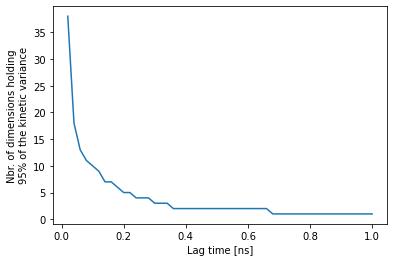

In [7]:
# Plot the number of dimension as a function of the selected lag time.
Xa = np.array(X)*20/1000 # Convert lag-times to ns 
plt.plot(Xa,Y)
plt.xlabel('Lag time [ns]')
plt.ylabel('Nbr. of dimensions holding\n95% of the kinetic variance')

We observe that the TICA dimensions rapidly decrease when increasing the lag-time at which the analysis is carried out. The system only needs two dimensions to explain 95% of the kinetic variance using a lag-time of 0.66 ns.

### Plotting the simulation into TICA space

To continue with our analysis, we will employ a lag-time of 33 (0.66ns). First, we estimate the TICA space and then convert all the featured data into TICA coordinates IC1 and IC2. After this, we plot the time progression of each TICA coordinate and their cumulative histograms.

In [8]:
# Define a lag time for TICA calculation
lag_time = 33

# Calculate TICA at a specfic lag time
tica = pyemma.coordinates.tica(ca_native_contacts_data, lag=lag_time)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)
ndim = tica_concatenated.shape[1]
print('Number of TICA Dimensions at lagtime %s: %s' % (lag_time, ndim))

Number of TICA Dimensions at lagtime 33: 2


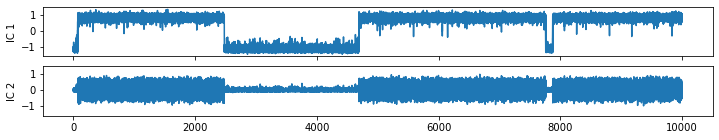

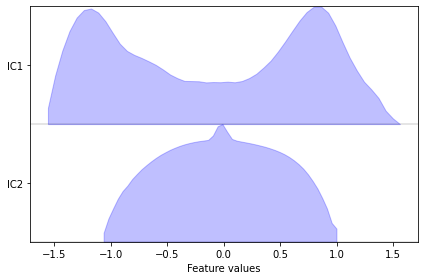

In [9]:
# Plot progression of TICA dimensions along the MD coordinate
fig, axes = plt.subplots(ndim, 1, figsize=(12, ndim), sharex=True, sharey=True)
x = 0.02 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
    
# Plot densities of TICA dimensions
fig, axes = plt.subplots(1, 1)
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes,
    feature_labels=['IC'+str(i) for i in range(1,ndim+1)],
    ylog=True)
fig.tight_layout()

We project our simulated data into all possible 2D TICA spaces. Since we only have two TICA dimensions, only one plot is generated. Be careful if the "tica" object contains many dimensions because the combinatorics will be huge!

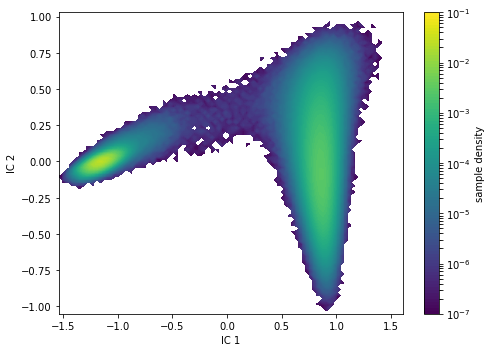

In [10]:
# Calculate all 2D combinations of the TICA space and generate a density plot for each one. 
# Note that if there are too many dimensions the calculation will be huge. Please limit the number of dimensions
# generated by the tica method in the above cells (e.g., pyemma.coordinates.tica(ndim=5)).

IC = {}
for i in range(tica_concatenated.shape[1]):
    IC[i] = tica_concatenated[:, i]
combinations = list(itertools.combinations(range(tica_concatenated.shape[1]), r=2))
fig, axes = plt.subplots(len(combinations), figsize=(7, 5*len(combinations)), sharey=True, sharex=True)
print()
for i,c in enumerate(combinations):
    if len(combinations) <= 1:
        pyemma.plots.plot_density(*np.array([IC[c[0]], IC[c[1]]]), ax=axes, logscale=True)
        axes.set_xlabel('IC '+str(c[0]+1))
        axes.set_ylabel('IC '+str(c[1]+1))
    else:
        pyemma.plots.plot_density(*np.array([IC[c[0]], IC[c[1]]]), ax=axes[i], logscale=True)
        axes[i].set_xlabel('IC '+str(c[0]+1))
        axes[i].set_ylabel('IC '+str(c[1]+1))

fig.tight_layout()

### Cluster analysis | VAMP2 score

Now that we have reduced our data dimensions to only two TICA coordinates, we will construct our MSM. To do this, we need to discretize the space into representative clusters of the data. This clusterization can be done by applying the k-means algorithm to generate representative groups over the TICA space. Since discretizing the trajectory data carries the risk of losing kinetic information and possibly introducing errors in the analysis, we will validate the number of clusters generated by their ability to explain the kinetic data. 

For the validation, we employ the VAMP-2 score as a heuristic of the kinetic variance. 

In [11]:
# Define number of clusters to evaluate
n_clustercenters = [5]+list(range(10,101,10))+list(range(120,201,20))+list(range(300,1001,100))

# Calculate the VAMP2 score of a MSM calculated with different number of k-means clusters.
scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=200, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, lag_time)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

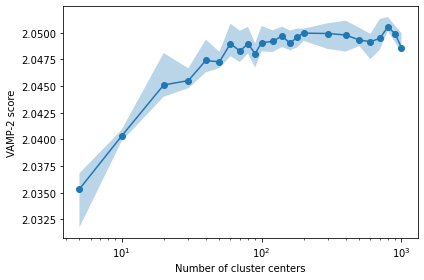

In [12]:
# Plot the VAMP2 score vs the number of clusters
fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('Number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

Based on the above result, we will select 1000 clusters to represent the Markov states of our Markov model. The representation is done by assigning to each TICA-projected frame a cluster's index.

In [13]:
# Select the number of clusters to build the MSM
n_clusters = 1000
# Calculate cluster in TICA space using the k-means algorithm
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=n_clusters, max_iter=100, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

We also plot the clusters' location in the 2D TICA space.

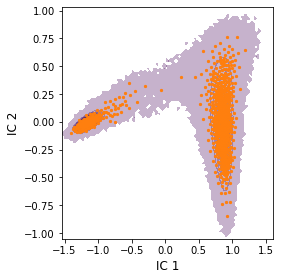

In [14]:
# Plot the k-means clusters into the first and second TICA dimensions
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1', fontsize=12)
ax.set_ylabel('IC 2', fontsize=12)
fig.tight_layout()

### Implied time scales (ITS)

Before moving into the MSM construction, we will validate the lag time selection by doing an implied-time scales analysis. The implied time scales (ITS) are computed from the eigenvalues of the MSM transition matrix. They represent the decorrelation times of the kinetic processes inside the transition matrix.

Here we will only consider the five slowest processes' ITSs by plotting them as a function of the selected lag-time.

In [15]:
# Define the lag times to evaluate (only use 5 eigenvalues)
its = pyemma.msm.its(cluster.dtrajs, lags=[ 1, 2, 3, 5, 8, 12, 20, 28, 33, 40, 50], nits=5, errors='bayes')

[ 1  2  3  5  8 12 20 28 33 40 50]


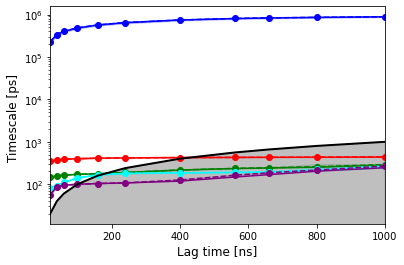

In [16]:
# Plot the ITS
pyemma.plots.plot_implied_timescales(its, dt=20, units='ps');
plt.xlabel('Lag time [ns]', fontsize=12)
plt.ylabel('Timescale [ps] ', fontsize=12)
print(its.lags)

We see that the ITSs become constant at the selected lag time of 0.66ns. At this lag-time, the MSM has only one relevant transition.

### Chapman-Kolmogorov test

Before moving into the origin of this relevant transition, we will further validate the MSM by running a Chapman-Kolmogorov (CK) test. Since we have only one relevant transition, this test is applied for a two-state MSM. 

Since the test is very costly memory-wise, we recommend running it in a separate notebook:

[Run Chapman-Kolmogorov Notebook](other_notebooks/Chapman_Kolmogorov.ipynb)

### Stationary distribution and free energy

We are ready now to build our MSM for the folding simulation. We employ a lag-time of 33 (0.66 ns), and we use a thousand k-means clusters.

In [17]:
# Calcualte a Bayesian Markov State Model 
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag_time, dt_traj='20 ps')

Now we plot the stationary distribution and the free energy for our system:

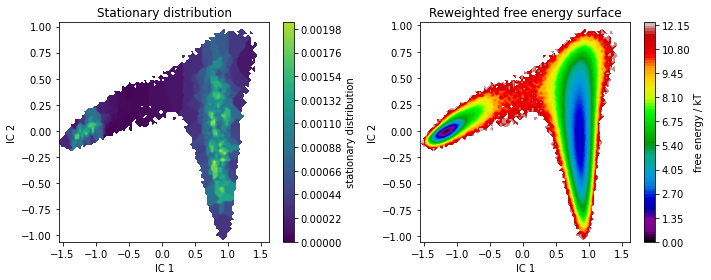

In [18]:
# Plot stationary distribution and free energy
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[1].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution')
axes[1].set_title('Reweighted free energy surface')
fig.tight_layout()

The system has two clear minima separated by the IC1 coordinate (FoxP1 is a two-state folder). On the other hand, the IC2 coordinate describes dynamical transitions inside each basin.

### Second right eigenvector

Since we are interested in the MSM transition matrix's slowest process, we plot its second eigenvector, associated with the slowest process in the simulation. 

Text(0, 0.5, 'IC 2')

<Figure size 432x288 with 0 Axes>

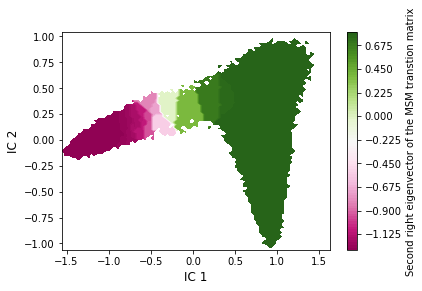

In [19]:
eigvec = msm.eigenvectors_right()
fig = plt.figure()
fig.tight_layout()
i=0
pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i+1],
        cmap='PiYG',
        cbar_label='Second right eigenvector of the MSM transtion matrix',
        mask=True)
plt.xlabel('IC 1', fontsize=12)
plt.ylabel('IC 2', fontsize=12)

We observe that the slowest transition happens between the two free energy minima. 

### PCCA++ clustering into 2 states

By using the above information, we can now divide our simulation into two kinetically-relevant macrostates. We do this by applying the PCCA++ clustering method to assign each configuration to a specific metastable state.

In [20]:
nstates = 2
msm.pcca(nstates)

PCCA(P=array([[0.00297, 0.     , ..., 0.     , 0.     ],
       [0.     , 0.00241, ..., 0.00185, 0.00222],
       ...,
       [0.     , 0.00178, ..., 0.00107, 0.00231],
       [0.     , 0.00115, ..., 0.00125, 0.00211]]),
   m=2)

To visualize this transition's location in the 2D TICA space, we plot a crisp assignment of the macrostates.

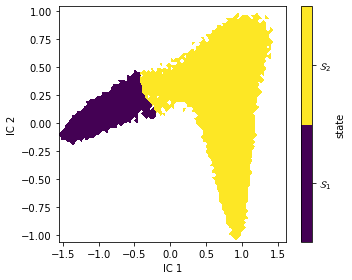

In [21]:
# Plot crisp partitioning of metastable states
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()

### Radius of gyration

To know which configurations are associated with each macrostate, we plot the radius of gyration (ROG) distribution of each basin.

However, since reading into memory all trajectories is very costly, we recommend making the calculations in a separate notebook:

[Calculate radius of gyration here](other_notebooks/radiusOfGyration.ipynb)

In [22]:
# Load radius of gyration result file
rg_concatenated = np.load('output/radiusOfGyration.npy')

We first take a look at the ROG distribution in the 2D TICA space:

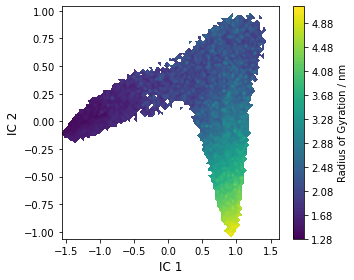

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    np.ravel(rg_concatenated),
    ax=ax,
    mask=True,
    cbar_label=r'Radius of Gyration / nm')
ax.set_xlabel('IC 1', fontsize=12)
ax.set_ylabel('IC 2', fontsize=12)
fig.tight_layout()

It is clear that when moving from one basing to the other there is an increase in ROG. Now we select the values for each of the macrostates, and plot their respective ROG distribution:

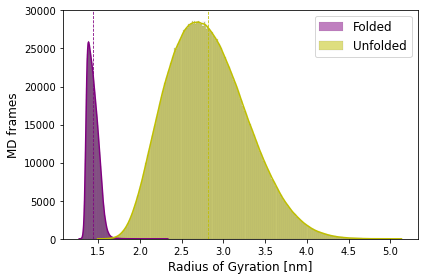

In [24]:
# Plot the ROG distribution for each macrostate
rg_traj = np.ravel(rg_concatenated)
labels = ['Folded', 'Unfolded']
color = ['purple', 'y']
fig, ax = plt.subplots()
# iterate over macrostates
for num, metastable_set in enumerate(msm.pcca(2).metastable_sets):
    traj_indices = np.where(np.isin(dtrajs_concatenated, metastable_set))[0]
    # plot histogram distribution
    hist = sns.histplot(rg_traj[traj_indices], color=color[num], label=labels[num], kde=True)
    # plot average ROG value
    ax.axvline(rg_traj[traj_indices].mean(), c=color[num], lw=0.8, ls='--')
    
ax.legend(fontsize=12)
ax.set_xlabel(r'Radius of Gyration [nm]', fontsize=12)
ax.set_ylabel(r'MD frames', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)
fig.tight_layout()

Based on the above result, we see that the left basin is associated with the folded state and that the right basin with unfolded one. We can now calculate the free energies of these basins as follows:

In [25]:
print('state\tπ\t\tG [kT]')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, p, -np.log(p)))

state	π		G [kT]
1	0.381601	0.963379
2	0.618399	0.480622


The unfolded basin has a higher probability of being visited than the folded one. These probabilities say that our temperature is slightly above the actual folding temperature for this AA-SBM model.

### Folding transition state

Finally, we would like to locate the transition state surface for the folding transition. We do this by applying Transition Path Theory to calculate the commitor function of the transition.

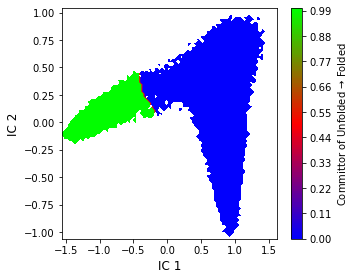

In [26]:
# Estimate the comittor function for the U -> F transition
start, final = 1, 0
A = msm.metastable_sets[start]
B = msm.metastable_sets[final]
flux = pyemma.msm.tpt(msm, A, B)

cg, cgflux = flux.coarse_grain(msm.metastable_sets)
fig, ax = plt.subplots(figsize=(5, 4))

fig, ax, contour = pyemma.plots.plot_contour(
                   *tica_concatenated[:, :2].T,
                   flux.committor[dtrajs_concatenated],
                   cmap='brg',
                   ax=ax,
                   mask=True,
                   cbar_label=r'Committor of Unfolded $\to$ Folded')

ax.set_xlabel('IC 1', fontsize=12)
ax.set_ylabel('IC 2', fontsize=12)
fig.tight_layout()

By definition, the commitor function is 0.5 at the TS; therefore, the red line in the above plot represents the folding process' TS region. Having this definition, we can gather configurations near or at the TS region to query them for the FoxP1 folding mechanism. We define a TICA-space distance to the TS (TS_distance) and pick all configurations as close to the TS region. 

In practice, we use the TS line (red line) defined in the above TST contour plot to determine the TS location numerically. Then we calculate the distance of each configuration to all the line points. If the smaller of these distances is less or equal to the TS distance threshold, then the configuration is considered in the TS region.

In [27]:
# Get all points for the TS line
p1 = contour['mappable'].collections[1].get_paths()[0]
v1 = p1.vertices
x1 = v1[:,0]
y1 = v1[:,1]
ts_location = np.array([x1,y1]).T

# Calculate TS membership for all trajectories
TS_distance = 0.02 
TS_state_frames = {}
for i,tica_traj in enumerate(tica_output):
    # Distance of the configurations' TICA coordinates to the TS line
    diff = tica_traj - ts_location[:, np.newaxis] # Broadcast differences
    tsd = np.min(np.linalg.norm(diff, axis=2), axis=0)
    # Only get configurations inside the TS region
    TS_state_frames[i] = np.argwhere(tsd < TS_distance).T[0]
    
# Save TS frames indexes into a file
for i in TS_state_frames:
    with open('output/ts_frames'+str(i+1).zfill(2)+'.npy', 'w') as ts_frames_file:
        np.savetxt(ts_frames_file, TS_state_frames[i])

Since we need to load the full trajectories to access the TS surface frames, we have saved each trajectory's ts frame's indexes into different files ('output/ts_frames_x_.json'). With this information, we now open a separate notebook to create a single trajectory containing all the TS frames:

[Create TS trajectory notebook](other_notebooks/getTStrajectory.ipynb)

After the trajectory has been created, we loaded it here and continue with the analysis. 

We continue by reading the TS trajectory file:

In [28]:
ts_traj_file = 'output/ts_trajectory.dcd'
ts_trajectory = md.load(ts_traj_file, top=structure_file)
print(ts_trajectory)

<mdtraj.Trajectory with 73 frames, 747 atoms, 88 residues, without unitcells>


Instead of looking at each configuration in the TS idependently, we will calculate the probability of native contact formation at the TS. For this we create a function that generates the contact probability matrix, by counting the formation of each native contact in each frame in the TS configurations.

In [29]:
def getContactProbabilityMatrix(traj_files, structure_file, contact_file):
    """
    Calculates the alpha carbon native contact formation probability for a 
    set of trajectory files. The native contact definition is read from a 
    contact file. A contact is considered formed if the distance is lower 
    than 1.05 times the native contact's equilibrium value.
    
    Parameters
    ----------
    
    traj_files : str or list or tuple
        The paths to the trajectory files. The upper matrix is filled with the contact map 
        and the lower matrix is filled with the information derived from the trajectory files.
    structure_file : str
        Path to the PDB structure file.
    contact_file : str
        Path to the native contact file.
        
    Returns
    -------
    M : np.ndarray
        Native contact formation probability matrix 
    """
    
    if isinstance(traj_files, str):
        traj_files = [traj_files]
    
    # Read forcefield parameters to extract native contacts
    AA_sbmModel = sbmOpenMM.models.getAllAtomModel(structure_file, contact_file, default_parameters=False)
    
    # Calculate native contacts
    ca_native_contacts = getCAcontacts(AA_sbmModel)
    
    # Calculate native contacts
    native = md.load(structure_file)
    native_distances = md.compute_distances(native, ca_native_contacts)
    
    # Calculate the probability of contact formation
    nc_count = np.zeros(native_distances.shape[1])
    N = 0
    for traj_file in traj_files:
        traj = md.load(traj_file, top=structure_file)
        traj_distances = md.compute_distances(traj, ca_native_contacts)
        nc_count += np.sum(np.where(traj_distances <= native_distances*1.05, 1.0, 0), axis=0)
        N += traj_distances.shape[0]
    probability = nc_count/N
        
    # Create matrix
    residue_native_contacts = getCAcontacts(AA_sbmModel, residue_index=True)
    n_res = AA_sbmModel.topology.getNumResidues()
    M = np.zeros((n_res, n_res))
        
    for i,p in enumerate(probability):
        r = residue_native_contacts[i]
        M[r[0]-1][r[1]-1] = p
        M[r[1]-1][r[0]-1] = 1.0
    M[M == 0 ] = np.nan
                
    return M

Now we get the contact probability matrix and plot it together with the native contacts of FoxP1

Generating AA SBM for structure file input/FoxP_monomer.pdb

Setting up geometrical parameters:
_________________________________
Removing hydrogens from topology
Added 747 atoms
Added 767 bonds
Added 1038 angles
Added 855 torsions
Added 166 impropers
Added 357 planars
Reading contacts from contact file: input/FoxP_monomer.contacts
Added 822 native contacts



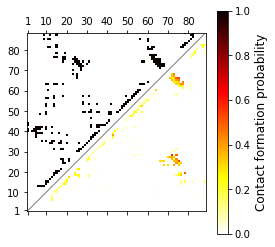

In [30]:
# Calcualate contact probability formation at the TS
M = getContactProbabilityMatrix(ts_traj_file, structure_file, contact_file)

# Plot native contacts and native contact formation probability
plt.matshow(M, cmap='hot_r', vmin=0, vmax=1.0, origin='lower')
cbar = plt.colorbar()

# Plot an identity line to separate the upper and lower half-matrices
plt.plot([0,87],[0,87], c='k', ls='-', lw=0.5)
cbar.set_label('Contact formation probability', size=12)

# Plot residue numbers every ten. 
xticks = plt.xticks(np.insert(np.arange(9, 87, 10), 0, 0), np.insert(np.arange(10, 88, 10), 0, 1))
yticks = plt.yticks(np.insert(np.arange(9, 87, 10), 0, 0), np.insert(np.arange(10, 88, 10), 0, 1))

We observe that, at the TS, contacts made by the beta-sheets are still formed before going to the unfolded state.